In [64]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.datasets import co2, get_rdataset

from plotnine import *

from statsmodels.tsa.seasonal import seasonal_decompose, STL

from statsmodels.tsa.filters.hp_filter import hpfilter

from statsmodels.tsa.stattools import adfuller, kpss

import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

from scipy.stats import shapiro, kstest, normaltest
from statsmodels.stats.diagnostic import kstest_normal, normal_ad

from statsmodels.tsa.api import AutoReg

from statsmodels.stats.api import (het_breuschpagan, het_goldfeldquandt, het_white)

from scipy.stats import boxcox

from statsmodels.stats.diagnostic import acorr_ljungbox



import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller, seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
from pathlib import Path

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.api import ExponentialSmoothing

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox

In [65]:
# Dataset: co2
co2_df = co2.load_pandas().data
co2_df = co2_df.ffill()

# Dataset: AirPassengers
air_passengers = get_rdataset("AirPassengers")
airp_df = air_passengers.data
airp_df.index = pd.date_range('1949', '1961', freq='M')
airp_df.drop(columns=['time'], inplace=True)

# Dataset
url1='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/life_expectancy_birth.csv'
url2='https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/milk_production.csv'

life = pd.read_csv(url1, 
                   index_col='year',
                   parse_dates=True,
                  skipfooter=1)

milk = pd.read_csv(url2, 
                   index_col='month', 
                   parse_dates=True)

C:\Users\Pc\AppData\Local\Temp/ipykernel_2264/3748741975.py:15: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.


# NÃO SAZIONAL ARIMA

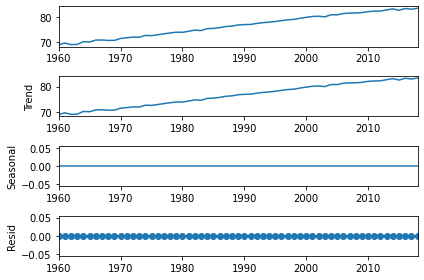

In [66]:
decomposed = seasonal_decompose(life)
decomposed.plot(); plt.show()

# Não tem efeito sazonal, mas tem tendência

In [67]:
# Testes estatísticos
    #  ADF: a hipótese nula afirma que existe uma raiz unitária na série temporal e, portanto, é não estacionária. 
    #  KPSS: tem a hipótese nula oposta, que assume que a série temporal é estacionária. 

def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05: 
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])


life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.556218967600307e-14 	 lags:1


('Stationary', 1.556218967600307e-14)

<AxesSubplot: xlabel='year'>

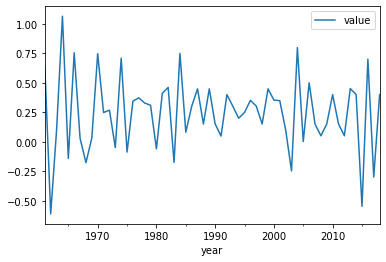

In [68]:
life_df1.plot()

# Os gráficos ACF e PACF ajudarão você a estimar os valores p e q apropriados para os modelos AR e MA, respectivamente. Use plot_acf e plot_pacf nos dados estacionários life_df1:

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.


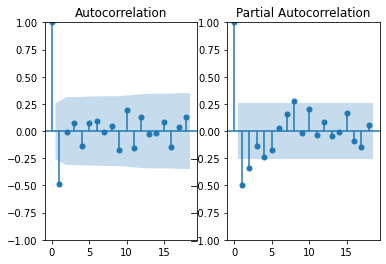

In [69]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]); plt.show()

# AM(1): nNo ACF, temos um lag significativo
# AR(0): no pacf, temos um movimento oscilatóro, típico de um AM(1). Além disso, temos um lag significativo

In [70]:
# SPLIT: Função para criar train e test data set
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [71]:
# Definindo dados de treino e teste

test_split = 0.15

milk_train, milk_test = split_data(milk, test_split)

life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [72]:
# Utilizar os dados com tendência (original) para performar o modelo ARIMA
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Tue, 29 Nov 2022   AIC                             52.321
Time:                        22:42:14   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

1. Agora, você precisará validar os resíduos do modelo para determinar se o modelo ARIMA que você construiu capturou os sinais na série temporal.

2. A suposição é que, se o modelo capturou todas as informações, os resíduos da previsão do modelo são aleatórios (ruído) e não seguem um padrão. 

Por exemplo, você não espera nenhuma autocorrelação nos resíduos. Comece usando o teste acorr_ljungbox nos resíduos. Você não deve esperar nenhuma autocorrelação:

In [73]:
acorr_ljungbox(results.resid, \
                lags=25,\
                return_df=True).head(5)           

,lb_stat,lb_pvalue
1,0.001308,0.971148
2,0.012111,0.993963
3,0.012491,0.999630
4,0.018173,0.999959
5,0.022673,0.999996


In [74]:
# H0: resíduos são não autocorrelacionados
(acorr_ljungbox(results.resid, \
                lags=25,\
                return_df=True) < 0.05)['lb_pvalue'].sum()
# O resultado mostra 0, que é um agregado dos resultados das primeiras 25 defasagens, indicando nenhuma autocorrelação                

0

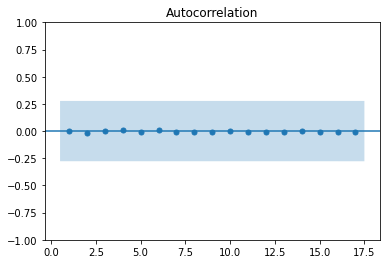

In [75]:
plot_acf(results.resid, zero=False);plt.show()

# Isso deve produzir um gráfico ACF. Aqui você esperaria que o gráfico não mostrasse atrasos significativos. 
# Em outras palavras, todas as linhas verticais devem estar mais próximas de zero ou em zero para todos os lags:

- Você também pode inspecionar a distribuição dos resíduos. Por exemplo, você esperaria resíduos normalmente distribuídos com média zero. Você pode usar o gráfico QQPlot e Kernel Density Estimation (KDE) para observar a distribuição e avaliar normalidade. Você pode fazer isso com o método plot_diagnostics:

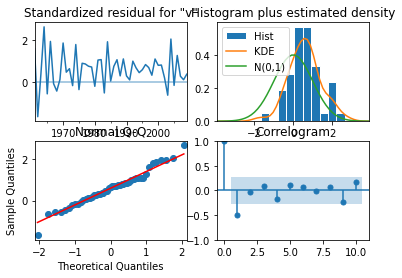

In [76]:
results.plot_diagnostics();plt.show()

- Os gráficos mostram um ligeiro desvio de uma distribuição normal. Por exemplo, um conjunto de dados normalmente distribuído perfeito terá um gráfico KDE curvado em forma de sino perfeito e todos os pontos estarão perfeitamente alinhados na linha no QQPlot. Até agora, os resultados e diagnósticos indicam um modelo decente, embora possa haver espaço para melhorias. Construir um modelo ARIMA pode ser um processo iterativo que envolve criar e testar diferentes modelos

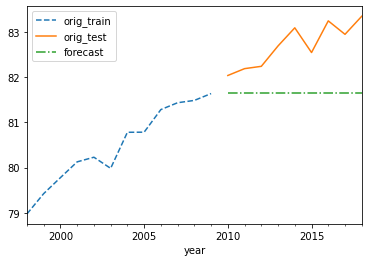

In [77]:
# A etapa final é criar uma previsão (previsão) e compará-la com seu conjunto de dados de teste (invisível ou fora dos dados de amostra).

# Função: Crie a função plot_forecast, que usa um objeto de modelo que você treinou, uma posição inicial e os conjuntos de dados de treinamento 
# e teste para criar um gráfico que compara a previsão (valores previstos) com os reais.

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

plot_forecast(results, '1998', life_train, life_test)


# A linha tracejada (previsão) não parece seguir a tendência esperada. Compare isso com os resultados do modelo de suavização exponencial 
# Para resolver isso, você pode executar vários modelos ARIMA com valores diferentes (p, d, q) e comparar as pontuações RMSE, MAPE, AIC ou BIC 
# para escolher o modelo mais adequado.

In [78]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

In [80]:
# Função: Melhor modelo para determinado criterio
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [81]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv ])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_train.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'RMSPE': rmspe(y, y_hat),
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}
best_m = get_best_model(score, 'AIC')

c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was pro

Best model: 8 with lowest AIC score: 7.69824797648488


c:\Users\Pc\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals


In [82]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Tue, 29 Nov 2022   AIC                              7.698
Time:                        22:43:18   BIC                             13.312
Sample:                    01-01-1960   HQIC                             9.820
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9452      4.985     -0.390      0.696     -11.717       7.826
ma.L2          0.9974      5.106      0.195      0.845      -9.011      11.006
sigma2         0.0500      0.257      0.194      0.846      -0.454       0.554
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
# Para visualizar os resultados de todos os 27 modelos em um DataFrame (formato tabular), você pode usar o seguinte comando:
pd.DataFrame(score).T.sort_values(by='AIC').reset_index() 


,index,order,AIC,RMSPE,BIC,AICc,RMSE,MAPE,model
0,8,"(0, 2, 2)",7.698248,1.654408,13.311851,8.243703,12.370896,0.164673,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
1,14,"(1, 1, 2)",9.533201,1.638433,17.100482,10.442292,12.239879,0.162931,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
2,17,"(1, 2, 2)",9.677102,1.653312,17.161906,10.607334,12.362189,0.164557,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
3,23,"(2, 1, 2)",11.509872,1.636784,20.968974,12.905221,12.226642,0.162754,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
4,26,"(2, 2, 2)",13.833852,1.759634,23.189857,15.262423,13.211998,0.175674,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,25,"(2, 2, 1)",19.672789,1.714935,27.157593,20.603021,12.865889,0.171131,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,16,"(1, 2, 1)",23.19374,1.697371,28.807343,23.739194,12.729545,0.169339,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,22,"(2, 1, 1)",25.294346,1.686974,32.861628,26.203437,12.646663,0.168259,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
8,7,"(0, 2, 1)",31.316646,1.698678,35.059048,31.583313,12.741947,0.169492,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
9,13,"(1, 1, 1)",33.425771,1.67413,39.101232,33.959104,12.546147,0.166938,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


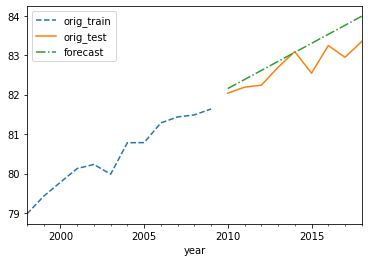

In [84]:
plot_forecast(best_m, '1998', life_train, life_test)
